# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [2]:
!pip -q install datasets

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn as sns
sns.set(palette='summer')
sns.set_style("darkgrid")

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [4]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [5]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [6]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [7]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [8]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Baseline model

In [11]:
class BaselineModel(nn.Module):
    def __init__(self, hidden_dim: int,
                 vocab_size: int,
                 num_classes: int = len(np.unique(eval_dataset.data["label"])),
                 aggregation_type: str="max"):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=.1)
        self.aggregation_type = aggregation_type


    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.activation(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.activation(output))  # [batch_size, num_classes]

        return prediction

In [17]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [13]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = BaselineModel(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 90.30
Лучшая accuracy для подхода mean: 90.98


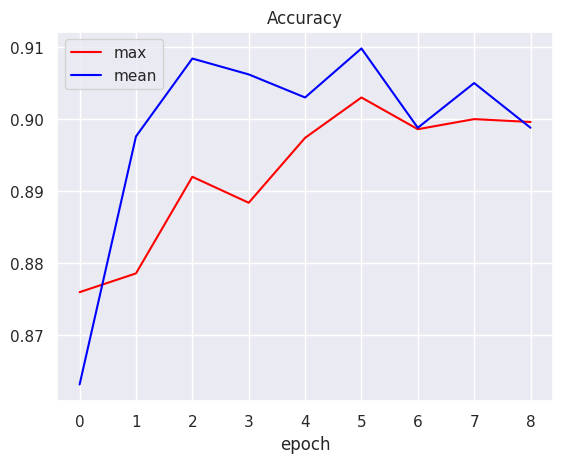

In [14]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [15]:
evaluate(model)

0.9065999984741211

In [16]:
class BetterModel(nn.Module):
    def __init__(self, hidden_dim: int,
                 vocab_size: int,
                 num_classes: int = len(np.unique(eval_dataset.data["label"])),
                 aggregation_type: str="max"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn1 = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn1(embeddings)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn2(output)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
          output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.activation(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.activation(output))  # [batch_size, num_classes]

        return prediction

In [15]:
def train(model, criterion, optimizer, aggregation_type, scheduler=None, num_epochs=5):
    eval_steps = len(train_dataloader) // 2

    model = model.to(device)

    losses, acc = [], []

    print(f"Starting training for {aggregation_type}")
    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()
            
        if scheduler is not None:
            scheduler.step()
        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 90.78
Лучшая accuracy для подхода mean: 90.46


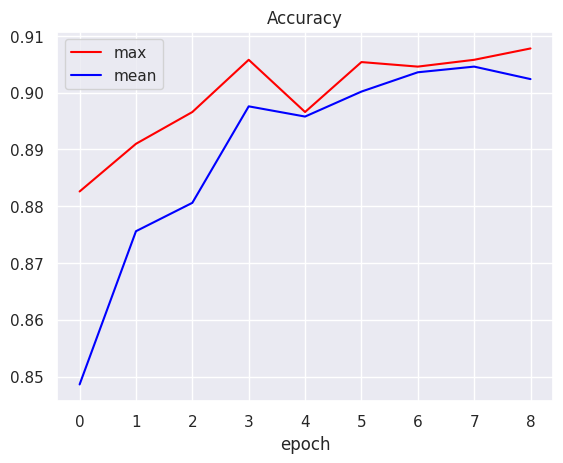

In [20]:
losses_type = {}
acc_type = {}

for aggregation_type in "max", "mean":
    model = BetterModel(hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type) # Added GRU layer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    losses, acc = train(model, criterion, optimizer, aggregation_type)
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [21]:
evaluate(model)

0.9013999700546265

Заменил один слой RNN на GRU. Если обобщать, то разницы никакой, качество сравнимо с `Baseline model`, но с одним слоем GRU не было пика до 0.91

In [22]:
class BetterModel_LSTM(nn.Module):
    def __init__(self, hidden_dim: int,
                 vocab_size: int,
                 num_classes: int = len(np.unique(eval_dataset.data["label"])),
                 aggregation_type: str="max"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn1 = nn.LSTM(hidden_dim, hidden_dim)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn1(embeddings)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn2(output)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.activation(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.activation(output))  # [batch_size, num_classes]

        return prediction

In [11]:
from torch.optim.lr_scheduler import StepLR

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 81.58
Лучшая accuracy для подхода mean: 56.22


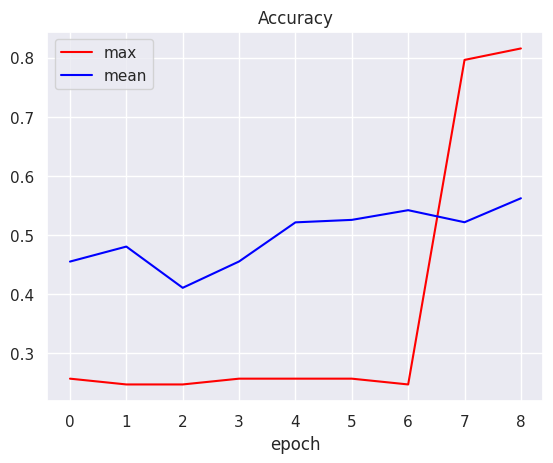

In [24]:
losses_type = {}
acc_type = {}

for aggregation_type in "max", "mean":
    model = BetterModel_LSTM(hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type) # Added 2 LSTM layers
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


    losses, acc = train(model, criterion, optimizer, aggregation_type, scheduler, num_epochs=5)
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [25]:
evaluate(model)

0.557200014591217

Заменил оба ванильных слоя RNN на LSTM. Качество резко упало, модель стала крайне склонной к переобучению, причём очень быстро.

In [26]:
class LSTM2(nn.Module):
    def __init__(self, hidden_dim: int,
                  vocab_size: int,
                  num_classes: int = len(np.unique(eval_dataset.data["label"])),
                  aggregation_type: str="max",
                  num_layers: int = 3,
                  dropout: float = 0.2):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.activation(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.activation(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 26.12
Лучшая accuracy для подхода mean: 88.38


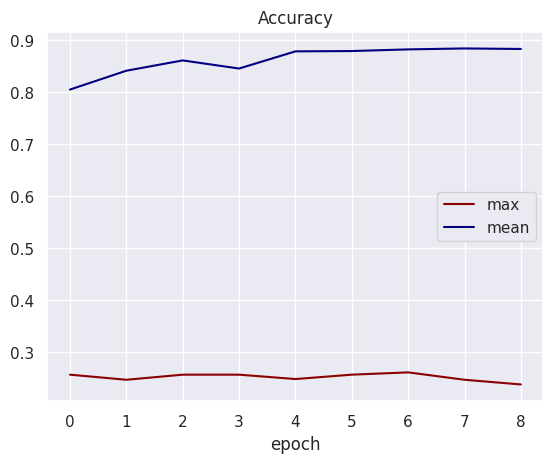

In [27]:
losses_type = {}
acc_type = {}

for aggregation_type in "max", "mean":
    model = LSTM2(hidden_dim=128, vocab_size=len(vocab), aggregation_type=aggregation_type) # Added 3 LSTM layers
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


    losses, acc = train(model, criterion, optimizer, aggregation_type, scheduler, num_epochs=5)
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

for (name, values), color in zip(losses_type.items(), ['darkred', 'navy']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [28]:
evaluate(model)

0.8829999566078186

Пытаясь бороться с переобучением, оставил только один слой LSTM. Качество классификации низковато по всем меркам, а для вида аггрегации "max" вообще в нуле. Однако модель стала менее склонна к переобучению

In [9]:
class LSTM_skip(nn.Module):
    def __init__(self, hidden_dim: int,
                 vocab_size: int,
                 num_classes: int = len(np.unique(eval_dataset.data["label"])),
                 aggregation_type: str="max",
                 num_layers: int = 3,
                 dropout: float = 0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(hidden_dim if i == 0 else hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
            for i in range(num_layers)
        ])
        
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_dim * 2) for _ in range(num_layers)])
        self.linear1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.projection = nn.Linear(hidden_dim // 2, num_classes)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.aggregation_type = aggregation_type

        
    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        output = embeddings
        for lstm, norm in zip(self.lstm_layers, self.layer_norms):
            residual = output
            output, _ = lstm(output)
            output = norm(output)
            if output.size() == residual.size():
                output = output + residual
            output = self.dropout(output)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]  # [batch_size, hidden_dim*2]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)  # [batch_size, hidden_dim*2]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear1(self.activation(output)))  # [batch_size, hidden_dim]
        output = self.dropout(self.linear2(self.activation(output)))  # [batch_size, hidden_dim//2]
        prediction = self.projection(self.activation(output))  # [batch_size, num_classes]

        return prediction

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода mean: 92.20


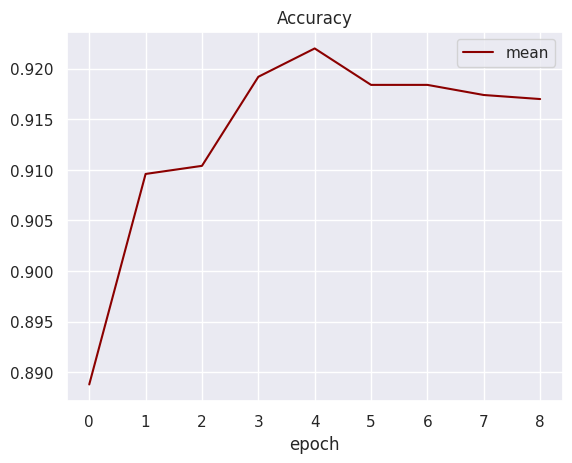

In [21]:
losses_type = {}
acc_type = {}

for aggregation_type in ["mean"]:
    model = LSTM_skip(hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type, num_layers=3) # Added batchnorm, changed to GRU
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


    losses, acc = train(model, criterion, optimizer, aggregation_type, scheduler, num_epochs=5)
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

for (name, values), color in zip(losses_type.items(), ['darkred', 'navy']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [22]:
evaluate(model)

0.9179999828338623

А вот теперь получилось наконец-то. Играясь с архитектурами, я обнаружил, что для более корректной классификации модель рада видеть больше линейных слоёв, но с LSTM в купе, она очень быстро переобучалась. Тогда я решил накинуть LayerNorm на эти слои, чтобы балансировать распределения, а также подключил дропаут для борьбы с переобучением. В итоге модель перестала вообще что-либо выучивать.

Пришлось добавить ещё LSTM слоёв, и вот это уже позволило качественно выполнить задачу. Экспериментально было установлено, что наилучшее качество достигается с помощью типа аггрегации "max", поэтому "mean" не указывается на графике (модель довольно тяжелая и не так уж быстро училась, что тоже повлияло на моё решение убрать ещё один тип аггрегации)

Итак.
* Необоснованное увеличение количества слоёв LSTM/GRU не привело к ожидаемому улучшению качества классификации. Напротив, наблюдался эффект переобучения, выраженный в резком снижении метрик качества модели на валидационной выборке.
* LayerNorm -- благо, сильно помогает в обучении и взаимосвязи между несколькими LSTM слоями. LayerNorm стабилизирует градиенты, что ускоряет сходимость и способствует более эффективному обучению глубоких RNN.
* Dropout также сильно помог мне бороться с переобучением. Однако, вероятно, текущая конфигурация модели использует избыточный уровень Dropout, и его применение можно оптимизировать, сократив количество слоёв, на которые он применяется.

Тем не менее, невзирая на все описанные ухищрения и модификации, кажется, что сеть должна быть куда проще. BaselineModel состояла из одного однонаправленного RNN-слоя и показывала качество на ~0.1 хуже. Полагаю, что моя модель -- конкретный оверкилл, но тем не менее она работает и удовлетворяет всем требованиям по качеству.

Ну и мой косяк -- стоило изменить код функции `train` для прямого сохранения конфигурации моделей для более корректного оценивания. Но было и так всё видно по графикам